In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [4]:
#load & Preprocess
(train_ds, test_ds)  = tfds.load("tf_flowers",
                                 split = ["train[:70%]", "train[:30%]"],
                                 as_supervised=True)
IMG_SIZE = (150,150)
NUM_CLASSES = 5

def preprocess(img,label):
    img = tf.image.resize(img,IMG_SIZE)
    img = preprocess_input(img)
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

train_ds = train_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1762779445.492622     511 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
#Load pre-trained VGG16 model
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))
base_model.trainable = False

model = models.Sequential ([
    base_model,
    layers.Flatten(),
    layers.Dense(64,activation ='relu'),
    layers.Dense(NUM_CLASSES,activation ='softmax')
])

In [7]:
# Compile and Train
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(train_ds, validation_data = test_ds, epochs = 3)

Epoch 1/3


2025-11-10 13:02:58.959202: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-10 13:02:59.058285: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ef83400ccd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-10 13:02:59.058318: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-11-10 13:02:59.156671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-10 13:02:59.591474: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-11-10 13:02:59.670618: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficien

80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6157 - loss: 5.0871

2025-11-10 13:03:35.042445: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-10 13:03:35.927681: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-10 13:03:36.897667: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-10 13:03:37.456026: W external/local_xla/xla/ts

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.6168 - loss: 5.0546

2025-11-10 13:03:49.502608: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 577ms/step - accuracy: 0.7030 - loss: 2.4580 - val_accuracy: 0.8837 - val_loss: 0.3269
Epoch 2/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.8844 - loss: 0.3461 - val_accuracy: 0.9446 - val_loss: 0.1570
Epoch 3/3
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - accuracy: 0.9478 - loss: 0.1538 - val_accuracy: 0.9673 - val_loss: 0.0974


In [9]:
# Fine-tune (Unfreeze top layers)
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile  (optimizer = tf.keras.optimizers.Adam(1e-5),
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

fine_history = model.fit(train_ds,validation_data = test_ds, epochs = 2)

# Evaluate
loss, acc = model.evaluate(test_ds)
print("Final Accuracy:", acc)

Epoch 1/2
81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - accuracy: 0.9763 - loss: 0.0730 - val_accuracy: 0.9882 - val_loss: 0.0307
Epoch 2/2
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 339ms/step - accuracy: 0.9875 - loss: 0.0331 - val_accuracy: 0.9909 - val_loss: 0.0244
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9909 - loss: 0.0244
Final Accuracy: 0.9909173250198364


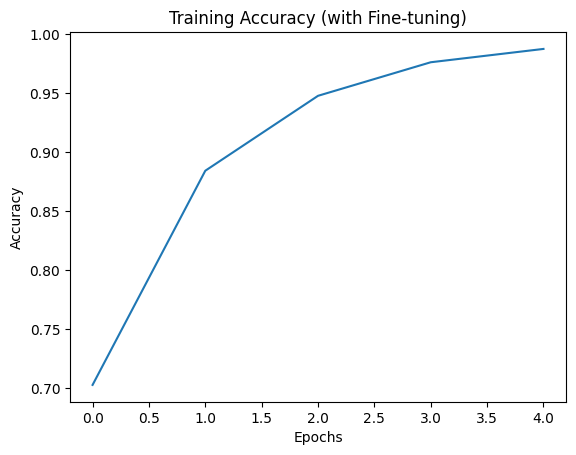

In [10]:
#plot
plt.plot(history.history['accuracy'] + fine_history.history['accuracy'])
plt.title('Training Accuracy (with Fine-tuning)')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.show()